참고자료 : https://www.kaggle.com/pednt9/gwd-keras-unet-starter

**해결 방향**

train image + bounding box -> mask

test image -> mask -> bounding box 

## 데이터 가져오기

### Loading Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(2) # gpu idx

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.measure import label, regionprops
from PIL import Image, ImageDraw
from ast import literal_eval
from tqdm.notebook import tqdm

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras import backend as K

/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/tensorflow/pyth

### Reading data

In [3]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512

## '..'는 상위폴더로 가는 것
TRAIN_PATH = '../Wheat/train/'
TEST_PATH = '../Wheat/test/'
SC_FACTOR = int(1024 / IMG_WIDTH)

warnings.filterwarnings('ignore')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
PATH = "../Wheat/"
train_folder = os.path.join(PATH, "train")
test_folder = os.path.join(PATH, "test")
train_csv_path = os.path.join(PATH, "train.csv")
df = pd.read_csv(train_csv_path)
sample_sub = pd.read_csv(PATH + "sample_submission.csv")

df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [6]:
print(os.listdir(TEST_PATH))

['aac893a91.jpg', '2fd875eaa.jpg', '348a992bb.jpg', '51f1be19e.jpg', '51b3e36ab.jpg', 'cc3532ff6.jpg', 'f5a1f0358.jpg', 'cb8d261a3.jpg', '53f253011.jpg', '796707dd7.jpg']


os.listdir() : path 경로의 파일명을 리스트에 저장.

## 경계 상자를 Mask로 변환

In [7]:
def make_polygon(coords):
    xm, ym, w, h = coords
    xm, ym, w, h = xm / SC_FACTOR, ym / SC_FACTOR, w / SC_FACTOR, h / SC_FACTOR   # scale values if image was downsized
    return [(xm, ym), (xm, ym + h), (xm + w, ym + h), (xm + w, ym)]

masks = dict() # 모든 마스크를 포함하는 dictionnary

for img_id, gp in tqdm(df.groupby("image_id")):
    gp['polygons'] = gp['bbox'].apply(eval).apply(lambda x: make_polygon(x))

    img = Image.new('L', (IMG_WIDTH, IMG_HEIGHT), 0)
    for pol in gp['polygons'].values:
        ImageDraw.Draw(img).polygon(pol, outline=1, fill=1)

    mask = np.array(img, dtype=np.uint8)
    masks[img_id] = mask


**<실행>** 
1. (for문) train 데이터 한 행의 bbox 값이 make_polygon(coords)이라는 함수에 의해 사각형의 4가지 좌표를 가지게 된다.
2. return 문으로 반환되어 gp['polygons']에 저장
3. Image.new()함수를 통해 512x512 이미지를 만들고 img에 저장(IMG_WIDTH = 512, IMG_HEIGHT = 512)
4. gp['polygons']를 img에 그림.
5. mask에 이미지 저장
6. masks 리스트에 img_id에 해당하는 mask저장


**<함수>**
* tqdm : for문의 상태바를 나타내주는 라이브러리
* groupby() : 집단, 그룹별로 데이터를 집계/요약
* lambda : 쓰고 버리는 일시적인 함수 x: --> x가 변수처럼 쓰임

### 첫 번째 이미지의 마스크에 대한 간단한 예를 그려 봅시다.

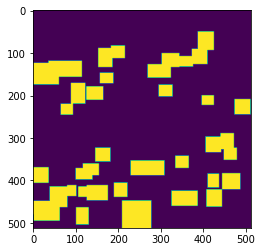

In [8]:
im = Image.fromarray(masks[list(masks.keys())[3372]])
plt.imshow(im)

3373번째 사진의 마스크를 그려보았다.

**#문제1 - 마스크에 해당하는 이미지 띄우기 (내가 작성해보기)**

## 데이터셋 로드하기

train 이미지와 마스크 가져 오기 (+크기 조정)

In [9]:
#X_train -> 사진 데이터, Y_train -> 마스크 데이터
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids[:]), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #크기가 조정된 이미지 저장
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)#이해x
    
    id_clean = id_.split('.')[0]#아이디만 분리해서 저장
    if id_clean in masks.keys():
        Y_train[n] = masks[id_clean][:, :, np.newaxis]#아이디에 해당하는 mask저장

# test이미지 가져오기/크기조정
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
sizes_test = list()
print('Getting and resizing test images...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path)
    sizes_test.append([img.shape[0], img.shape[1]])#이미지 크기 조정
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks... 



Getting and resizing test images...



Done!


* X_train, X_test -> 사진데이터 저장 공간, 3은 사진의 색을 표현하는 rgb 세 개의 값을 넣는 곳.

* Y_train -> 마스크데이터 저장 공간, 1은 마스크의 색을 표현하는 0과 1의 값을 넣는 곳.

* [:]리스트 전체
* resize() : 사진 크기를 다시 설정

In [10]:
X_train.shape, Y_train.shape

((3422, 512, 512, 3), (3422, 512, 512, 1))

X_train -> 3422개의 사진, 512x512 크기, rgb색(3겹)

Y_train -> 3422개의 마스크, 512x512 크기, 0 1로 이루어진 색(1겹)

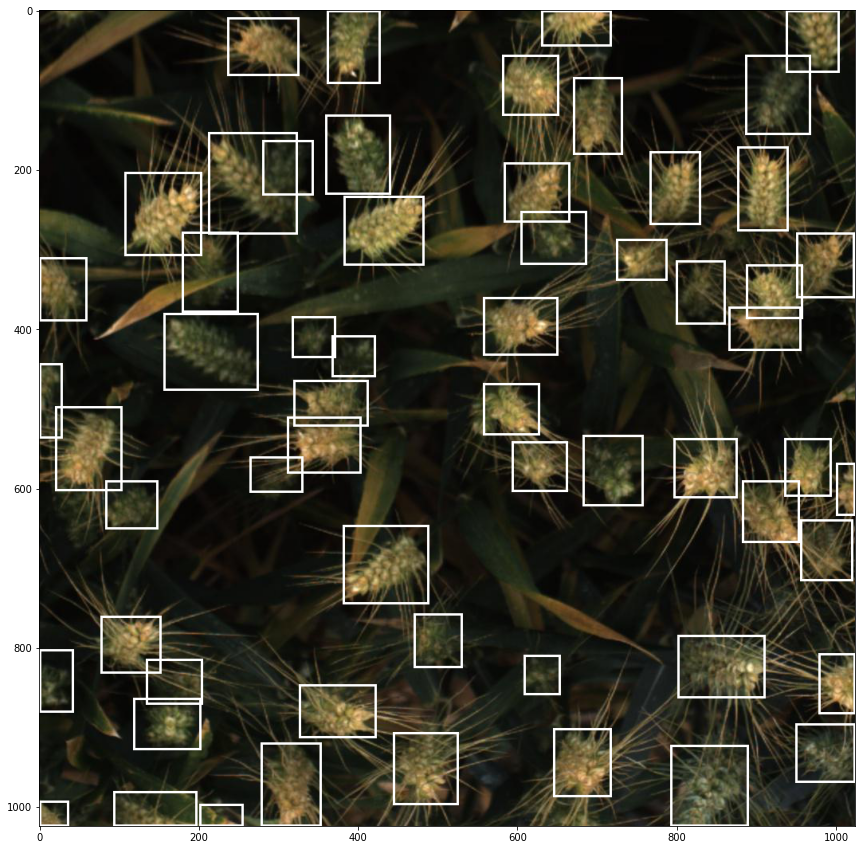

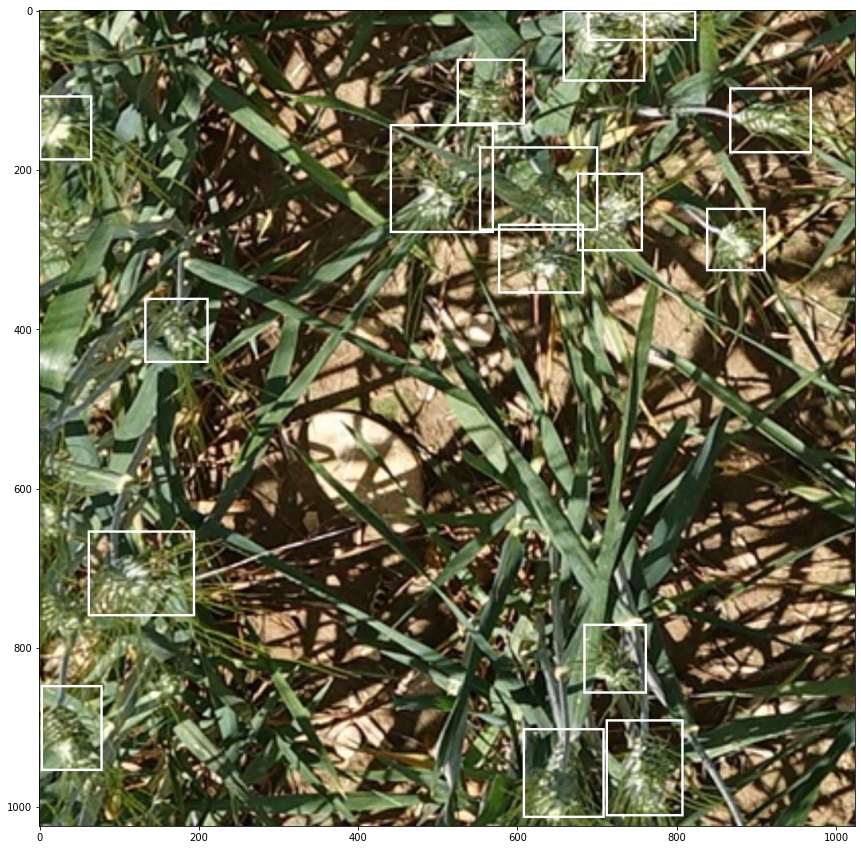

In [11]:
def show_images(images, num=2):
    
    images_to_show = np.random.choice(images, num)

    for image_id in images_to_show:

        image_path = os.path.join(train_folder, image_id + ".jpg")
        image = Image.open(image_path)

        # get all bboxes for given image in [xmin, ymin, width, height]
        bboxes = [literal_eval(box) for box in df[df['image_id'] == image_id]['bbox']]

        # visualize them
        draw = ImageDraw.Draw(image)
        for bbox in bboxes:    
            draw.rectangle([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], width=3)

        plt.figure(figsize = (15,15))
        plt.imshow(image)
        plt.show()


unique_images = df['image_id'].unique()
show_images(unique_images)

In [12]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred):

    tresholds = [0.5 + (i * 0.05)  for i in range(5)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [13]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)  # rescale inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[competitionMetric2])
model.summary()

W0727 23:22:02.119865 140208691042112 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0727 23:22:02.131398 140208691042112 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0727 23:22:02.135936 140208691042112 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0727 23:22:02.143796 140208691042112 deprecation_wrapper.py:119] From /home/hyejoo/.venv/py367tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png', show_shapes=True)
#from IPython.display import Image
#Image('model.png')

In [15]:
#Fit model


earlystop = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

model.fit(X_train, 
         Y_train,
         validation_split=0.1,
         batch_size=16, 
         epochs=10, 
         callbacks=[earlystop],
        )

Train on 3079 samples, validate on 343 samples
Epoch 1/10
3079/3079 [==============================] - 80s 26ms/step - loss: 0.4855 - competitionMetric2: 0.0555 - val_loss: 0.3874 - val_competitionMetric2: 0.1883
Epoch 2/10
3079/3079 [==============================] - 76s 25ms/step - loss: 0.3434 - competitionMetric2: 0.3623 - val_loss: 0.2989 - val_competitionMetric2: 0.4122
Epoch 3/10
3079/3079 [==============================] - 77s 25ms/step - loss: 0.2804 - competitionMetric2: 0.5797 - val_loss: 0.2722 - val_competitionMetric2: 0.5971
Epoch 4/10
3079/3079 [==============================] - 77s 25ms/step - loss: 0.2438 - competitionMetric2: 0.6959 - val_loss: 0.2470 - val_competitionMetric2: 0.6968
Epoch 5/10
3079/3079 [==============================] - 76s 25ms/step - loss: 0.2233 - competitionMetric2: 0.7658 - val_loss: 0.2111 - val_competitionMetric2: 0.7942
Epoch 6/10
3079/3079 [==============================] - 76s 25ms/step - loss: 0.2095 - competitionMetric2: 0.8110 - val_los

## Predicition

In [16]:
THRESH = 0.65

preds = model.predict(X_test)[:, :, :, 0]
masked_preds = preds > THRESH

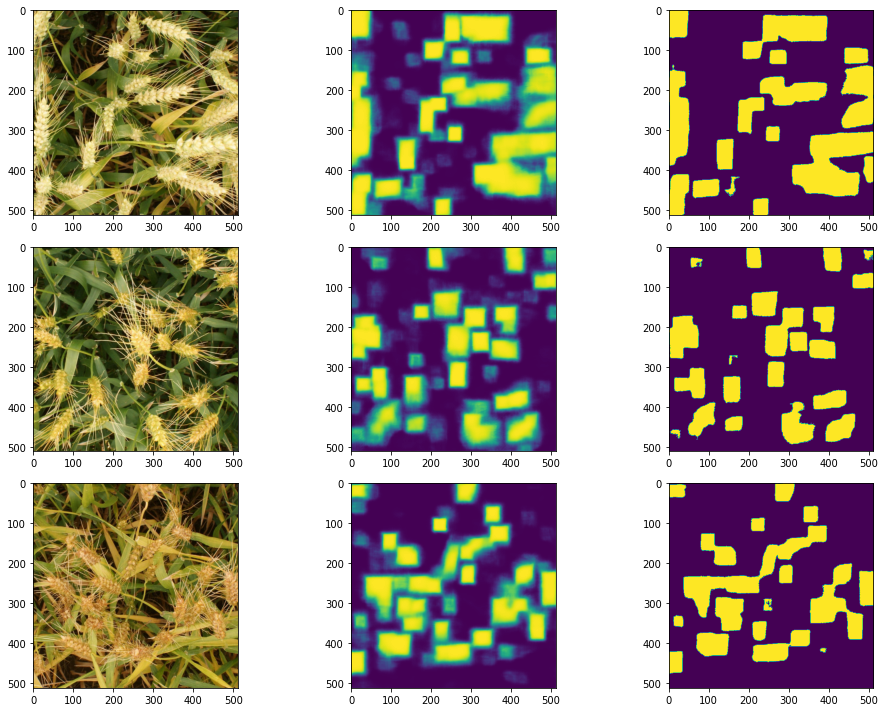

In [17]:
n_rows = 3
f, ax = plt.subplots(n_rows, 3, figsize=(14, 10))

for j, idx in enumerate([4,5,6]):
    for k, kind in enumerate(['original', 'pred', 'masked_pred']):
        if kind == 'original':
            img = X_test[idx]
        elif kind == 'pred':
            img = preds[idx]
        elif kind == 'masked_pred':
            masked_pred = preds[idx] > THRESH
            img = masked_pred
        ax[j, k].imshow(img)

plt.tight_layout()


In [18]:
def get_params_from_bbox(coords, scaling_factor=1):
    xmin, ymin = coords[1] * scaling_factor, coords[0] * scaling_factor
    w = (coords[3] - coords[1]) * scaling_factor
    h = (coords[2] - coords[0]) * scaling_factor
    
    return xmin, ymin, w, h

In [19]:
# Allows to extract bounding boxes from binary masks
bboxes = list()

for j in range(masked_preds.shape[0]):
    label_j = label(masked_preds[j, :, :]) 
    props = regionprops(label_j)   # that's were the job is done
    bboxes.append(props)

In [20]:
# Here we format the bboxes into the required format
output = dict()

for i in range(masked_preds.shape[0]):
    bboxes_processed = [get_params_from_bbox(bb.bbox, scaling_factor=SC_FACTOR) for bb in bboxes[i]]
    formated_boxes = ['1.0 ' + ' '.join(map(str, bb_m)) for bb_m in bboxes_processed]
    
    output[sample_sub["image_id"][i]] = " ".join(formated_boxes)

In [21]:
sample_sub["PredictionString"] = output.values()

In [22]:
sample_sub

,image_id,PredictionString
0,aac893a91,1.0 178 0 68 76 1.0 550 0 72 50 1.0 252 56 156...
1,51f1be19e,1.0 0 0 218 108 1.0 232 0 92 58 1.0 426 10 124...
2,f5a1f0358,1.0 142 38 112 86 1.0 540 38 70 92 1.0 660 44 ...
3,796707dd7,1.0 20 0 90 66 1.0 780 20 140 142 1.0 612 94 1...
4,51b3e36ab,1.0 0 0 98 140 1.0 366 24 426 222 1.0 874 186 ...
5,348a992bb,1.0 770 0 94 128 1.0 386 4 78 106 1.0 972 18 5...
6,cc3532ff6,1.0 528 0 100 92 1.0 0 4 86 70 1.0 670 114 76 ...
7,2fd875eaa,1.0 594 42 180 234 1.0 440 124 96 70 1.0 312 1...
8,cb8d261a3,1.0 18 36 246 156 1.0 770 50 52 46 1.0 312 68 ...
9,53f253011,1.0 334 0 100 58 1.0 628 34 164 116 1.0 956 88...


In [23]:
sample_sub.to_csv('submission.csv', index=False)